In [1]:
# Filtering out the warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Import the required Libraries.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Notes

- There could be multiple applications from the same customer
- Amounts -> Can they be rounded off?

AMT_APPLICATION, AMT_CREDIT, AMT_GOODS_PRICE
- Goods Vs Amount loan
- Is lesser amount given than that is asked for? AMT_APPLICATION	AMT_CREDIT	
- Is more amount asked for than that is needed? AMT_APPLICATION	AMT_GOODS_PRICE
- No information on whether the applicant has paid off the previous loans
- AMT_DOWN_PAYMENT & RATE_DOWN_PAYMENT occur together

Current Application & Previous Application
- Do all clients with current application have entries in previous application?
- For each Client, number of previous applications & how many were completed.
- 1 curr_id has multiple prev_ids. Add number of prev_ids associated with this curr_id

Others
- Replace all FLAG_DOCUMENT with a single FLAG_DOCUMENT with the sum
- Correlation matrix
- No information on whether the applicant has paid off the previous loans
- Columns have empty values
- Merge 2 datasets
- How to show/hide output - o

1. Data Cleaning: 
    - Remove the irrelevant columns. 
    - Remove/impute the missing values
2. Outlier handling:
    - Univariate: ordered or unordered, or it may be a numerical variable.
        - Categorical unordered:
        - Categorical ordered
        - Numerical variable: mean, median, mode, quantiles, and box plots, 
            - continuous
            - discrete 
        - Convert numerical variables into categorical ones
    - Multivariate  
        -  Bivariate: 
            - correlation and scatter plots on numerical variables
            - numerical and categorical variables: Boxplot
            - two categorical variables: bar graph
        -  Multivariate: heat maps 
3. Standardising values
Fixing invalid values
Filter data


### Table of Contents <a class="anchor" id="toc"></a>

* [Definitions](#definitions)
    * [Section 1.1](#section_1_1)
    * [Section 1.2](sSection_1_2)
        * [Section 1.2.1](#section_1_2_1)
        * [Section 1.2.2](#section_1_2_2)
        * [Section 1.2.3](#section_1_2_3)
* [Chapter 2](#chapter2)
    * [Section 2.1](#section_2_1)
    * [Section 2.2](#section_2_2)


## Problem Statement

## Definitions <a class="anchor" id="definitions"></a> [TOC](#toc)

In [3]:
def percent(val, total):
    return round(100 * val/total, 2)

def getIQR(df, col):
    Q1, Q3 = df[col].quantile(0.25), df[col].quantile(0.75)
    return Q3 - Q1

def getMaxScore(df, col):
    Q3 = df[col].quantile(0.75)
    iqr = getIQR(df, col)
    return Q3 + 1.5 * iqr

def listColumsWithMissingData(df):
    [ print(f"{col:30}  {df[col].isna().sum(): 7d} {100 * df[col].isna().sum()/df.shape[0]: 2.1f}%") for col in df.columns if df[col].isna().any() ]

def getCategoricalValues(df):
    cat_columns = df.select_dtypes(include=['object']).columns.tolist()
    cat_columns.sort()
    print(f"Columns with categorical values {len(cat_columns)} --> {cat_columns}")
    for col in cat_columns:
        count_values = df[col].unique().shape[0]
        print(f"{col:27} : [{count_values:2}] --> {sorted((df[col].unique().tolist())) if np.NaN not in df[col].unique().tolist() else (df[col].unique().tolist())}")
        
def getNumCategoricalValues(df, ncat_columns):
    ncat_columns.sort()
    print(f"Columns with categorical values {len(ncat_columns)}")
    for col in ncat_columns:
        count_values = df[col].unique().shape[0]
        if count_values > 30:
            print(f"{col:26} : [{count_values:4}] --> {sorted(df[col].unique().tolist()[:10])}...{sorted(df[col].unique().tolist()[-10:])}") 
        else:
            print(f"{col:26} : [{count_values:4}] --> {sorted(df[col].unique().tolist())}") 

def makeDFForTarget(df, col, taretVal):
    df_ = df[df['TARGET']==taretVal][[col,'TARGET']]
    cnt = df_.shape[0]
    df_ = groupByAndCount(df_, col, skipPercent=False)
    df_.rename(columns={'Count':f'Target={taretVal}'},inplace=True)
    #print(df_)
    return df_, cnt


def makeDFForTargets(df, col):
    df_1, cnt_1 = makeDFForTarget(df, col, 1)
    df_0, cnt_0 = makeDFForTarget(df, col, 0)
    print(cnt_1, cnt_0)

    df_ = df_0.merge(df_1, how='left',on=col)
    print(df_)
    df_.set_index(col, inplace=True)
    return df_


def groupByAndCount(df, col, sort = True, skipPercent=True):
    total_rows = df.shape[0]
    df_ = df.groupby(by=col).agg({col:"count"})
    df_.rename(columns={col:'Count'}, inplace=True)
    df_.reset_index(inplace=True)
    if sort == True: df_.sort_values(by='Count', ascending=False, inplace=True)
    if not skipPercent:
        df_['%'] = round((df_['Count']/total_rows)*100,2)
    return df_
    
def groupPerTarget(df, col):
    df_1 = df[df['TARGET']==1][[col,'TARGET']]
    cnt_1 = df_1.shape[0]
    df_1 = groupByAndCount(df_1, col, sort = False)
    df_1.rename(columns={'Count':'Target=1'},inplace=True)
    #print(df_1)

    df_0 = df[df['TARGET']==0][[ col,'TARGET']]
    cnt_0 = df_0.shape[0]
    df_0 = groupByAndCount(df_0, col, sort = False)
    df_0.rename(columns={'Count':'Target=0'},inplace=True)
    #print(df_0)


    df_ = df_0.merge(df_1, how='left',on=col)
    df_['Total'] = df_['Target=0'] + df_['Target=1']
    df_['Target=0%'] = percent(df_['Target=0'], df_['Total']) 
    df_['Target=1%'] = percent(df_['Target=1'], df_['Total'])
    df_.set_index(col, inplace=True)

    #df_[['Total', 'Target=1', 'Target=0']].astype('int32')
    df_= df_[['Total', 'Target=1', 'Target=0', 'Target=1%', 'Target=0%' ]]

    print(f"df_1: {cnt_1}, df_0: {cnt_0}")
    print(df_)
    
    return df_

# -----
def groupByTargetAndCount(df, value, sort = True, skipPercent=True):
    total_rows = df.shape[0]
    df_ = df.groupby(by='TARGET').agg({'TARGET':"count"})
    df_.rename(columns={'TARGET': f'{value}_Count'}, inplace=True)
    df_.reset_index(inplace=True)
    if sort == True: df_.sort_values(by=f'{value}_Count', ascending=False, inplace=True)
    if not skipPercent:
        df_[f'{value}_%'] = round((df_[f'{value}_Count']/total_rows)*100,2)
    return df_

def makeDFForTarget1(df, col, value):
    df_ = df[df[col]==value][[col,'TARGET']]
    #print(df_)
    cnt = df_.shape[0]
    df_ = groupByTargetAndCount(df_, value, skipPercent=False)
    return df_, cnt


def makeDFForTargets1(df, col):
    df_1, cnt_1 = makeDFForTarget1(df_ca, col, 'N')
    df_0, cnt_0 = makeDFForTarget1(df_ca, col, 'Y')
    print(cnt_1, cnt_0)
    df_ = df_0.merge(df_1, how='left',on='TARGET')
    print(df_)
    df_.set_index('TARGET', inplace=True)
    df_ = df_.transpose()
    df_ = df_.loc[['Y_%', 'N_%']]
    return df_
# ---

In [4]:
def plotBar(df, title, w=10, h=10, logy=False):
    plt.figure(figsize=(w, h), dpi=80)
    ax = df.plot.bar(logy=logy) 
    # Annotate
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.0f'), 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'center', 
                    xytext = (0, 9), 
                    textcoords = 'offset points')
    ax.set_title(title)
    plt.show()

def annotate(ax):
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.0f'), 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'center', 
                    xytext = (0, 9), 
                    textcoords = 'offset points')

def plotScatter(df, col1, col2, title, pos=1, log=False):
    plt.subplot(1, 2, pos)
    ax = df.plot.scatter(col1, col2,figsize=(10, 6))
    if log == True: ax.set_xscale('log')
    ax.set_title(title)
    plt.show()

# TODO: annotation - add %
def compare(df, col, title, labels=[], figsize=(10, 6)):
    df_ = groupPerTarget(df, col)

    plt.figure(dpi=80) #figsize=(20, 6),dpi=80
    plt.subplot(1, 2, 1)

    ax = df_[['Target=0','Target=1']].plot.bar(ax=plt.gca(), logy=True, figsize=figsize, rot=90)
    annotate(ax)
    if labels: ax.set_xticklabels(labels=labels, rotation=45)
    ax.set_title(f"{title} Vs Target - Absolute values")

    plt.subplot(1, 2, 2)
    ax = df_[['Target=0%','Target=1%']].plot.bar(ax=plt.gca(), logy=True, figsize=figsize)
    annotate(ax)
    if labels: ax.set_xticklabels(labels=labels, rotation=45)
    ax.set_title(f"{title} Vs Target - %age values")

## Data Exploration - Previous Application

### Data Reading & Data Types 

In [5]:
#Read the data in pandas
df_pa = pd.read_csv("data/previous_application.csv")

In [6]:
df_pa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 37 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   SK_ID_PREV                   1048575 non-null  int64  
 1   SK_ID_CURR                   1048575 non-null  int64  
 2   NAME_CONTRACT_TYPE           1048575 non-null  object 
 3   AMT_ANNUITY                  815566 non-null   float64
 4   AMT_APPLICATION              1048575 non-null  float64
 5   AMT_CREDIT                   1048575 non-null  float64
 6   AMT_DOWN_PAYMENT             489179 non-null   float64
 7   AMT_GOODS_PRICE              807610 non-null   float64
 8   WEEKDAY_APPR_PROCESS_START   1048575 non-null  object 
 9   HOUR_APPR_PROCESS_START      1048575 non-null  int64  
 10  FLAG_LAST_APPL_PER_CONTRACT  1048575 non-null  object 
 11  NFLAG_LAST_APPL_IN_DAY       1048575 non-null  int64  
 12  RATE_DOWN_PAYMENT            489179 non-nu

In [7]:
PA_COLUMNS = df_pa.columns.tolist()
PA_ID_COLUMNS = ['SK_ID_PREV','SK_ID_CURR']
PA_NCAT_COLUMNS = ['NFLAG_INSURED_ON_APPROVAL', 'NFLAG_LAST_APPL_IN_DAY', 'SELLERPLACE_AREA', 'HOUR_APPR_PROCESS_START']
print(len(max(PA_COLUMNS)))
getNumCategoricalValues(df_pa, PA_NCAT_COLUMNS)

26
Columns with categorical values 4
HOUR_APPR_PROCESS_START    : [  24] --> [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
NFLAG_INSURED_ON_APPROVAL  : [   3] --> [0.0, 1.0, nan]
NFLAG_LAST_APPL_IN_DAY     : [   2] --> [0, 1]
SELLERPLACE_AREA           : [2023] --> [-1, 6, 20, 35, 50, 61, 83, 130, 136, 200]...[1633, 1749, 1854, 1910, 2173, 2867, 3126, 3322, 5557, 6052]


In [8]:
getCategoricalValues(df_pa)

Columns with categorical values 16 --> ['CHANNEL_TYPE', 'CODE_REJECT_REASON', 'FLAG_LAST_APPL_PER_CONTRACT', 'NAME_CASH_LOAN_PURPOSE', 'NAME_CLIENT_TYPE', 'NAME_CONTRACT_STATUS', 'NAME_CONTRACT_TYPE', 'NAME_GOODS_CATEGORY', 'NAME_PAYMENT_TYPE', 'NAME_PORTFOLIO', 'NAME_PRODUCT_TYPE', 'NAME_SELLER_INDUSTRY', 'NAME_TYPE_SUITE', 'NAME_YIELD_GROUP', 'PRODUCT_COMBINATION', 'WEEKDAY_APPR_PROCESS_START']
CHANNEL_TYPE                : [ 8] --> ['AP+ (Cash loan)', 'Car dealer', 'Channel of corporate sales', 'Contact center', 'Country-wide', 'Credit and cash offices', 'Regional / Local', 'Stone']
CODE_REJECT_REASON          : [ 9] --> ['CLIENT', 'HC', 'LIMIT', 'SCO', 'SCOFR', 'SYSTEM', 'VERIF', 'XAP', 'XNA']
FLAG_LAST_APPL_PER_CONTRACT : [ 2] --> ['N', 'Y']
NAME_CASH_LOAN_PURPOSE      : [25] --> ['Building a house or an annex', 'Business development', 'Buying a garage', 'Buying a holiday home / land', 'Buying a home', 'Buying a new car', 'Buying a used car', 'Car repairs', 'Education', 'Everyday 

In [9]:
df_pa[df_pa.columns.difference(PA_ID_COLUMNS + PA_NCAT_COLUMNS)].describe()

,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,CNT_PAYMENT,DAYS_DECISION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_TERMINATION,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED
count,815566.000000,1.048575e+06,1.048575e+06,4.891790e+05,8.076100e+05,815569.000000,1.048575e+06,627867.000000,627867.000000,627867.000000,627867.000000,627867.000000,489179.000000,3721.000000,3721.000000
mean,15891.265151,1.742698e+05,1.950000e+05,6.700778e+03,2.262892e+05,15.995639,-8.820381e+02,342387.346201,13833.802031,76591.061435,33614.930898,81985.701661,0.079619,0.187177,0.774922
std,14745.557438,2.910789e+05,3.169407e+05,2.078570e+04,3.134490e+05,14.508109,7.792649e+02,88595.441587,72460.126454,149653.053854,106643.960780,153298.887247,0.107882,0.083343,0.099514
min,0.000000,0.000000e+00,0.000000e+00,-9.000000e-01,0.000000e+00,0.000000,-2.922000e+03,-2921.000000,-2892.000000,-2889.000000,-2801.000000,-2874.000000,-0.000014,0.034781,0.373150
25%,6301.350000,1.890000e+04,2.427750e+04,0.000000e+00,5.058000e+04,6.000000,-1.303000e+03,365243.000000,-1626.000000,-1313.000000,-1241.000000,-1269.000000,0.000000,0.160716,0.715645
50%,11250.000000,7.081650e+04,8.025300e+04,1.624500e+03,1.115116e+05,12.000000,-5.830000e+02,365243.000000,-830.000000,-537.000000,-361.000000,-498.000000,0.051062,0.189122,0.835095
75%,20523.003750,1.800000e+05,2.152395e+05,7.749000e+03,2.295000e+05,24.000000,-2.810000e+02,365243.000000,-410.000000,-74.000000,128.000000,-44.000000,0.108909,0.193330,0.852537
max,418058.145000,6.905160e+06,6.905160e+06,2.150100e+06,6.905160e+06,84.000000,-2.000000e+00,365243.000000,365243.000000,365243.000000,365243.000000,365243.000000,0.989740,1.000000,1.000000


In [10]:
df_pa.loc[df_pa['NAME_PRODUCT_TYPE']!='x-sell'][['NAME_PRODUCT_TYPE','NAME_SELLER_INDUSTRY']]

,NAME_PRODUCT_TYPE,NAME_SELLER_INDUSTRY
0,XNA,Connectivity
4,walk-in,XNA
6,XNA,XNA
7,XNA,XNA
8,XNA,XNA
...,...,...
1048570,XNA,Industry
1048571,XNA,XNA
1048572,XNA,Connectivity
1048573,XNA,Connectivity


In [11]:
df_pa[['NAME_PORTFOLIO', 'NAME_PRODUCT_TYPE','RATE_DOWN_PAYMENT', 'RATE_INTEREST_PRIMARY', 'RATE_INTEREST_PRIVILEGED', 'NAME_YIELD_GROUP', 'PRODUCT_COMBINATION']]

,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_YIELD_GROUP,PRODUCT_COMBINATION
0,POS,XNA,0.000000,0.182832,0.867336,middle,POS mobile with interest
1,Cash,x-sell,NaN,NaN,NaN,low_action,Cash X-Sell: low
2,Cash,x-sell,NaN,NaN,NaN,high,Cash X-Sell: high
3,Cash,x-sell,NaN,NaN,NaN,middle,Cash X-Sell: middle
4,Cash,walk-in,NaN,NaN,NaN,high,Cash Street: high
...,...,...,...,...,...,...,...
1048570,POS,XNA,0.108909,NaN,NaN,middle,POS other with interest
1048571,XNA,XNA,NaN,NaN,NaN,XNA,Cash
1048572,POS,XNA,0.102797,NaN,NaN,low_normal,POS mobile with interest
1048573,POS,XNA,0.208048,NaN,NaN,low_normal,POS mobile with interest


Check if there are multiple entries for each client in the previous application.

In [12]:
groupByAndCount(df_pa, 'SK_ID_PREV')

,SK_ID_PREV,Count
0,1000001,1
699055,2230833,1
699042,2230811,1
699043,2230814,1
699044,2230815,1
...,...,...
349530,1614974,1
349531,1614975,1
349532,1614977,1
349533,1614978,1


In [13]:
groupByAndCount(df_pa, 'SK_ID_CURR')


,SK_ID_CURR,Count
142103,265681,52
63263,173680,47
75369,187868,46
116034,235163,43
28387,133023,42
...,...,...
144146,268062,1
235260,374185,1
235258,374180,1
144149,268065,1


There is only one entry per client

Do all clients in current application have an entry in the previous application?

In [14]:
groupByAndCount(df_pa, 'NAME_CONTRACT_STATUS', skipPercent=False)

,NAME_CONTRACT_STATUS,Count,%
0,Approved,652486,62.23
1,Canceled,197231,18.81
2,Refused,182083,17.36
3,Unused offer,16775,1.60


In [15]:
groupByAndCount(df_pa, 'NAME_CONTRACT_TYPE', skipPercent=False)

,NAME_CONTRACT_TYPE,Count,%
0,Cash loans,465861,44.43
1,Consumer loans,461049,43.97
2,Revolving loans,121441,11.58
3,XNA,224,0.02


In [16]:
groupByAndCount(df_pa, 'NAME_CLIENT_TYPE', skipPercent=False)

,NAME_CLIENT_TYPE,Count,%
2,Repeater,771957,73.62
0,New,189990,18.12
1,Refreshed,85411,8.15
3,XNA,1217,0.12


In [17]:
df_pa['NAME_CLIENT_TYPE'].value_counts()

Repeater     771957
New          189990
Refreshed     85411
XNA            1217
Name: NAME_CLIENT_TYPE, dtype: int64

In [18]:
groupByAndCount(df_pa, 'NAME_PORTFOLIO', skipPercent=False)

,NAME_PORTFOLIO,Count,%
3,POS,436846,41.66
2,Cash,287509,27.42
4,XNA,233006,22.22
0,Cards,90935,8.67
1,Cars,279,0.03


In [19]:
groupByAndCount(df_pa, 'NAME_GOODS_CATEGORY', skipPercent=False)

,NAME_GOODS_CATEGORY,Count,%
27,XNA,593690,56.62
19,Mobile,141737,13.52
7,Consumer Electronics,77107,7.35
5,Computers,67082,6.40
2,Audio/Video,62910,6.00
11,Furniture,33931,3.24
22,Photo / Cinema Equipment,15779,1.50
6,Construction Materials,15754,1.50
4,Clothing and Accessories,14764,1.41
3,Auto Accessories,4706,0.45


In [20]:
groupByAndCount(df_pa, 'NAME_PRODUCT_TYPE', skipPercent=False)

,NAME_PRODUCT_TYPE,Count,%
0,XNA,670131,63.91
2,x-sell,284428,27.13
1,walk-in,94016,8.97


In [21]:
groupByAndCount(df_pa, 'CHANNEL_TYPE', skipPercent=False)

,CHANNEL_TYPE,Count,%
5,Credit and cash offices,451047,43.02
4,Country-wide,312690,29.82
7,Stone,134196,12.80
6,Regional / Local,68621,6.54
3,Contact center,41962,4.00
0,AP+ (Cash loan),35806,3.41
2,Channel of corporate sales,3958,0.38
1,Car dealer,295,0.03


In [22]:
groupByAndCount(df_pa, 'PRODUCT_COMBINATION', skipPercent=False)

,PRODUCT_COMBINATION,Count,%
2,Cash,178352,17.01
9,POS household with interest,166869,15.91
13,POS mobile with interest,139176,13.27
8,Cash X-Sell: middle,89806,8.56
7,Cash X-Sell: low,80873,7.71
0,Card Street,70951,6.77
11,POS industry with interest,62492,5.96
10,POS household without interest,52747,5.03
1,Card X-Sell,50490,4.82
3,Cash Street: high,37235,3.55


In [23]:
df_pa['RATE_DOWN_PAYMENT'].isna().sum() 

559396

In [24]:
df_pa['interest'] = np.NaN
df_pa['interest'].isna().sum() 

1048575

In [25]:
df_pa['interest'] = df_pa.apply(lambda x: x['RATE_DOWN_PAYMENT'] + x['RATE_INTEREST_PRIMARY'] + x['RATE_INTEREST_PRIVILEGED'], axis=1)

In [26]:
df_pa['interest'] 

0          1.050168
1               NaN
2               NaN
3               NaN
4               NaN
             ...   
1048570         NaN
1048571         NaN
1048572         NaN
1048573         NaN
1048574         NaN
Name: interest, Length: 1048575, dtype: float64

In [27]:

PRODUCT_COMBINATION_COLUMNS = ['interest', 'NAME_PORTFOLIO', 'NAME_GOODS_CATEGORY', 'NAME_PRODUCT_TYPE',   'NAME_YIELD_GROUP', 	'PRODUCT_COMBINATION']

In [28]:
df_pa[PRODUCT_COMBINATION_COLUMNS]

,interest,NAME_PORTFOLIO,NAME_GOODS_CATEGORY,NAME_PRODUCT_TYPE,NAME_YIELD_GROUP,PRODUCT_COMBINATION
0,1.050168,POS,Mobile,XNA,middle,POS mobile with interest
1,NaN,Cash,XNA,x-sell,low_action,Cash X-Sell: low
2,NaN,Cash,XNA,x-sell,high,Cash X-Sell: high
3,NaN,Cash,XNA,x-sell,middle,Cash X-Sell: middle
4,NaN,Cash,XNA,walk-in,high,Cash Street: high
...,...,...,...,...,...,...
1048570,NaN,POS,Jewelry,XNA,middle,POS other with interest
1048571,NaN,XNA,XNA,XNA,XNA,Cash
1048572,NaN,POS,Mobile,XNA,low_normal,POS mobile with interest
1048573,NaN,POS,Mobile,XNA,low_normal,POS mobile with interest


In [29]:
# TODO: Change this to .csv
df_columns = pd.read_excel("data/columns_description.xlsx")
df_columns.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160 entries, 0 to 159
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   160 non-null    int64  
 1   Table        160 non-null    object 
 2   Unnamed: 2   16 non-null     object 
 3   Category     154 non-null    object 
 4   Values       45 non-null     object 
 5   Common       8 non-null      float64
 6   Type         160 non-null    object 
 7   Remarks      21 non-null     object 
 8   Unnamed: 8   36 non-null     object 
 9   Row          160 non-null    object 
 10  Description  160 non-null    object 
 11  Special      69 non-null     object 
 12  Unnamed: 12  3 non-null      object 
dtypes: float64(1), int64(1), object(11)
memory usage: 16.4+ KB


In [30]:
PA_CONTRACT_COLUMNS = df_columns[(df_columns['Table']=='previous_application.csv') & (df_columns['Category']=='CONTRACT')]['Row'].tolist()
PA_CONTRACT_COLUMNS

['NAME_CONTRACT_TYPE',
 'AMT_ANNUITY',
 'AMT_APPLICATION',
 'AMT_CREDIT',
 'AMT_DOWN_PAYMENT',
 'RATE_DOWN_PAYMENT',
 'RATE_INTEREST_PRIMARY',
 'RATE_INTEREST_PRIVILEGED',
 'NAME_CONTRACT_STATUS',
 'NAME_PAYMENT_TYPE']

In [31]:
df_pa_contract = df_pa[['SK_ID_PREV']  + PA_CONTRACT_COLUMNS]

In [32]:
df_pa_contract['AMT_APP_CRED_DIFF'] = df_pa_contract['AMT_APPLICATION'] - df_pa_contract['AMT_CREDIT']
df_pa_contract['AMT_APP_GOOD_DIFF'] = df_pa['AMT_APPLICATION'] - df_pa['AMT_GOODS_PRICE']

In [33]:
df_pa_contract['AMT_APP_CRED_DIFF'] 

0              0.0
1         -72171.0
2         -23944.5
3         -20790.0
4         -66555.0
            ...   
1048570    21096.0
1048571        0.0
1048572     1543.5
1048573     5247.0
1048574    21757.5
Name: AMT_APP_CRED_DIFF, Length: 1048575, dtype: float64

In [34]:
# Is the application amount > the goods price? Is the credit amount < application amount? 
df_pa_contract_ = df_pa_contract[(df_pa_contract['AMT_APP_GOOD_DIFF'] > 0) | (df_pa_contract['AMT_APP_CRED_DIFF'] > 0)] [['SK_ID_PREV', 'NAME_CONTRACT_TYPE', 'NAME_CONTRACT_STATUS', 'AMT_APP_CRED_DIFF', 'AMT_APP_GOOD_DIFF']]

In [35]:
df_pa_contract_.to_csv("out/temp.csv")

In [36]:
# Looks like AMT_DOWN_PAYMENT & RATE_DOWN_PAYMENT occur together. Check if there is AMT_DOWN_PAYMENT if there is no RATE_DOWN_PAYMENT? 
df_pa[ ((df_pa['RATE_DOWN_PAYMENT'] == 0) | (df_pa['RATE_DOWN_PAYMENT'].isna() == True)) & (df_pa['AMT_DOWN_PAYMENT'] > 0) ][['SK_ID_PREV', 'RATE_DOWN_PAYMENT', 'AMT_DOWN_PAYMENT']] #

,SK_ID_PREV,RATE_DOWN_PAYMENT,AMT_DOWN_PAYMENT


In [37]:
df_pa.loc[df_pa['NAME_CONTRACT_STATUS'] == 'Refused'].to_csv("out/refused.csv")

In [38]:
df_pa_curr_ids = groupByAndCount(df_pa, 'SK_ID_CURR')

In [39]:
df_pa_curr_ids

,SK_ID_CURR,Count
142103,265681,52
63263,173680,47
75369,187868,46
116034,235163,43
28387,133023,42
...,...,...
144146,268062,1
235260,374185,1
235258,374180,1
144149,268065,1


In [40]:
df_pa_curr_ids[df_pa_curr_ids['Count'] == 1].shape[0]

82414

In [41]:
df_pa_curr_ids[df_pa_curr_ids['Count'] > 1].to_csv("out/multiple_curr_id.csv")

In [42]:
curr_ids_multiple_prev_app = df_pa_curr_ids[df_pa_curr_ids['Count'] > 1]['SK_ID_CURR'].tolist()

In [43]:
curr_ids_multiple_prev_app[0:4]

[265681, 173680, 187868, 235163]

## Data Exploration - Current Application

In [44]:
df_ca_orig = pd.read_csv("data/application_data.csv")

In [45]:
def dropColumns(df, cols):
    print(f"Shape - before cleanup {df.shape}")
    df.drop(columns = cols, inplace=True)
    print(f"Shape - after cleanup {df.shape}")

### Data Cleaning - Remove invalid data
 - EXT_SOURCE_1, EXT_SOURCE_2, EXT_SOURCE_3: Meaning of the columns/variables is not known

In [46]:
dropColumns(df_ca_orig, ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3'])

Shape - before cleanup (307511, 122)
Shape - after cleanup (307511, 119)


In [47]:
df_ca_orig['TARGET'].isna().sum()

0

There are no rows with TARGET variable not filled. So nothing to drop.

In [48]:
df_ca = df_ca_orig.copy(deep=True)
print(df_ca.shape)

(307511, 119)


### Categories
Categorize the columns/variables into groups for analysis

In [49]:
DEMOGRAPHIC_PERSONAL = [ 'CODE_GENDER', 'DAYS_BIRTH', 'CNT_CHILDREN', 'CNT_FAM_MEMBERS', 'NAME_FAMILY_STATUS', 
                            'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY']
DEMOGRAPHIC_PROFESSIONAL = [ 'NAME_EDUCATION_TYPE', 'NAME_INCOME_TYPE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE']

### 1. Demographic - PERSONAL

In [50]:
df_ca_demo_per = df_ca[DEMOGRAPHIC_PERSONAL + ['SK_ID_CURR', 'TARGET']]
print("Shape:",df_ca_demo_per.shape)
print("Numerical values - describe:\n"); print(df_ca_demo_per.describe())
print("Missing values:"); print(df_ca_demo_per.isna().sum())

Shape: (307511, 11)
Numerical values - describe:

          DAYS_BIRTH   CNT_CHILDREN  CNT_FAM_MEMBERS  \
count  307511.000000  307511.000000    307509.000000   
mean   -16036.995067       0.417052         2.152665   
std      4363.988632       0.722121         0.910682   
min    -25229.000000       0.000000         1.000000   
25%    -19682.000000       0.000000         2.000000   
50%    -15750.000000       0.000000         2.000000   
75%    -12413.000000       1.000000         3.000000   
max     -7489.000000      19.000000        20.000000   

       REGION_POPULATION_RELATIVE  REGION_RATING_CLIENT  \
count               307511.000000         307511.000000   
mean                     0.020868              2.052463   
std                      0.013831              0.509034   
min                      0.000290              1.000000   
25%                      0.010006              2.000000   
50%                      0.018850              2.000000   
75%                      0.02866

Missing values handling: CNT_FAM_MEMBERS has 2

df_1: 24825, df_0: 282686
                Total  Target=1  Target=0  Target=1%  Target=0%
CODE_GENDER                                                    
F            202448.0   14170.0    188278       7.00      93.00
M            105059.0   10655.0     94404      10.14      89.86
XNA               NaN       NaN         4        NaN        NaN
df_1: 24825, df_0: 282686
                         Total  Target=1  Target=0  Target=1%  Target=0%
NAME_FAMILY_STATUS                                                      
Civil marriage         29775.0    2961.0     26814       9.94      90.06
Married               196432.0   14850.0    181582       7.56      92.44
Separated              19770.0    1620.0     18150       8.19      91.81
Single / not married   45444.0    4457.0     40987       9.81      90.19
Unknown                    NaN       NaN         2        NaN        NaN
Widow                  16088.0     937.0     15151       5.82      94.18
df_1: 24825, df_0: 282686
                  

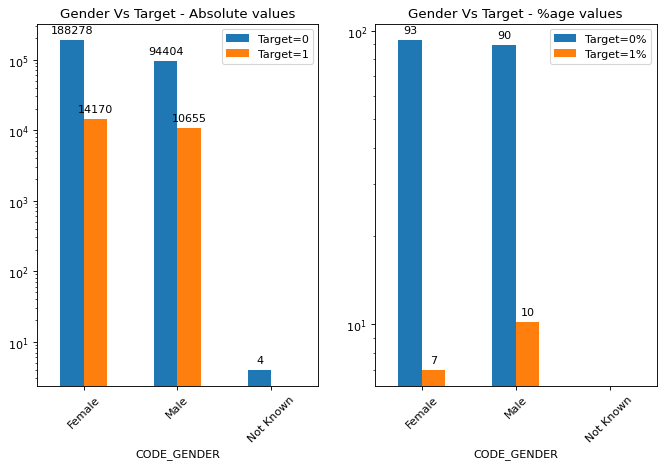

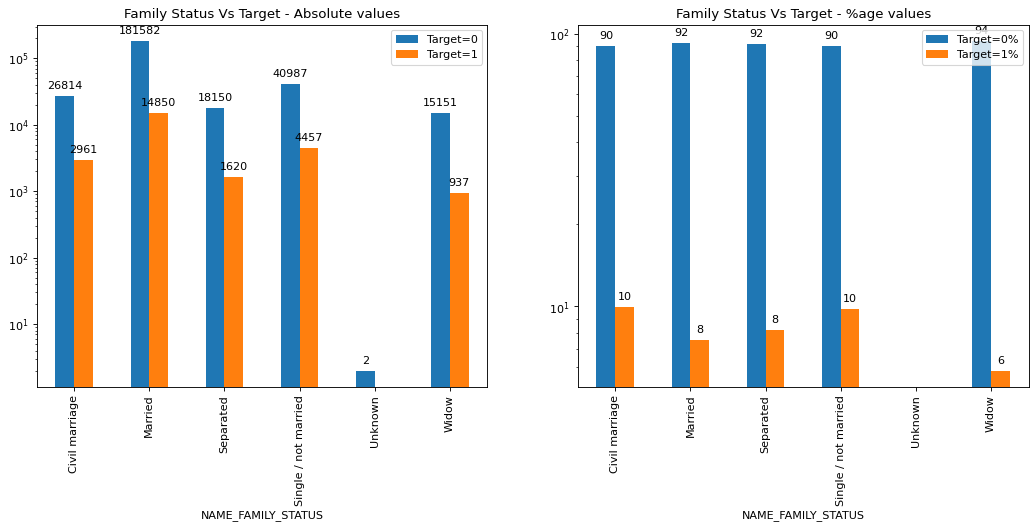

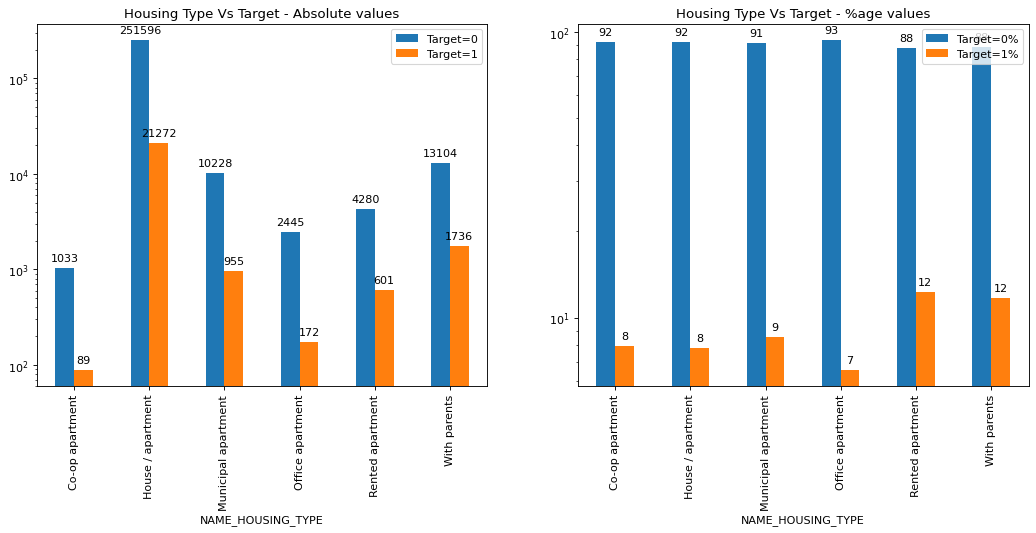

In [51]:
compare(df_ca_demo_per, 'CODE_GENDER', 'Gender', labels=['Female', 'Male', 'Not Known'])
compare(df_ca_demo_per, 'NAME_FAMILY_STATUS', 'Family Status', figsize=(16, 6)) 
compare(df_ca_demo_per, 'NAME_HOUSING_TYPE', 'Housing Type', figsize=(16, 6)) 

# TODO: 
# NAME_FAMILY_STATUS - Unknown: What should be done? Convert NaNs to 0

In [52]:
# DAYS_BIRTH 
# DAYS_BIRTH is a realative value to the application. Convert it to age.
df_ca_demo_per['AGE'] = (df_ca_demo_per['DAYS_BIRTH']/365)*(-1)

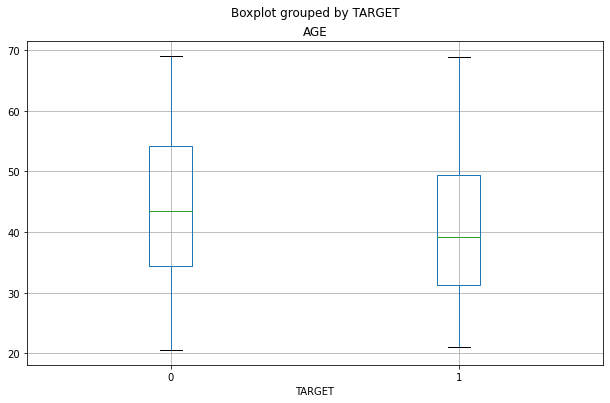

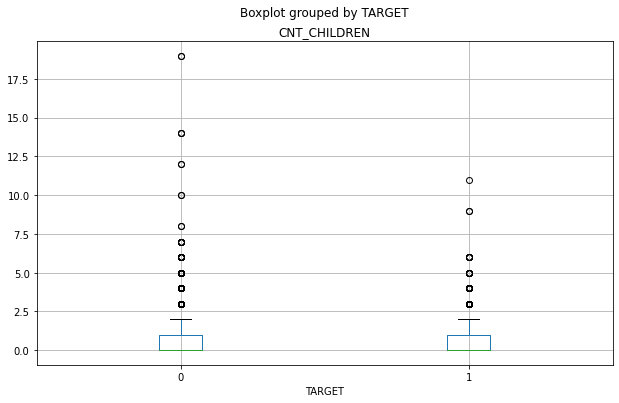

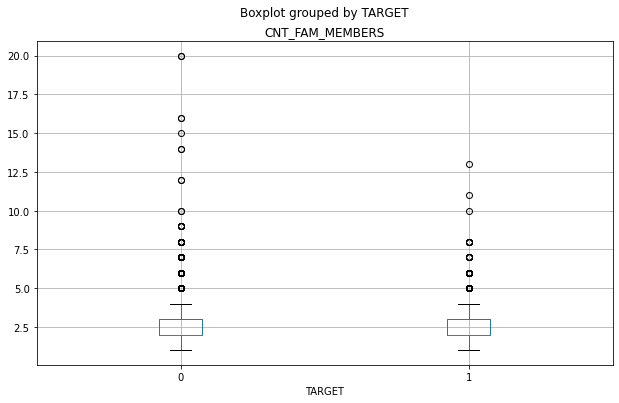

In [53]:
# Check for outliers
for col in ['AGE', 'CNT_CHILDREN', 'CNT_FAM_MEMBERS']: 
    df_ca_demo_per.boxplot(column=col, by='TARGET', figsize = (10, 6))

It would make sense to group the ages into more maangeable groups

In [54]:
df_ca_demo_per['AGE'] = pd.cut(df_ca_demo_per['AGE'], [20, 30, 40, 50, 60, 70], labels=['20-30', '30-40', '40-50', '50-60', '60-70'])

df_1: 24825, df_0: 282686
       Total  Target=1  Target=0  Target=1%  Target=0%
AGE                                                   
20-30  45021      5158     39863      11.46      88.54
30-40  82308      7888     74420       9.58      90.42
40-50  76541      5856     70685       7.65      92.35
50-60  68062      4172     63890       6.13      93.87
60-70  35579      1751     33828       4.92      95.08
df_1: 24825, df_0: 282686
                 Total  Target=1  Target=0  Target=1%  Target=0%
CNT_CHILDREN                                                    
0             215371.0   16609.0    198762       7.71      92.29
1              61119.0    5454.0     55665       8.92      91.08
2              26749.0    2333.0     24416       8.72      91.28
3               3717.0     358.0      3359       9.63      90.37
4                429.0      55.0       374      12.82      87.18
5                 84.0       7.0        77       8.33      91.67
6                 21.0       6.0        15 

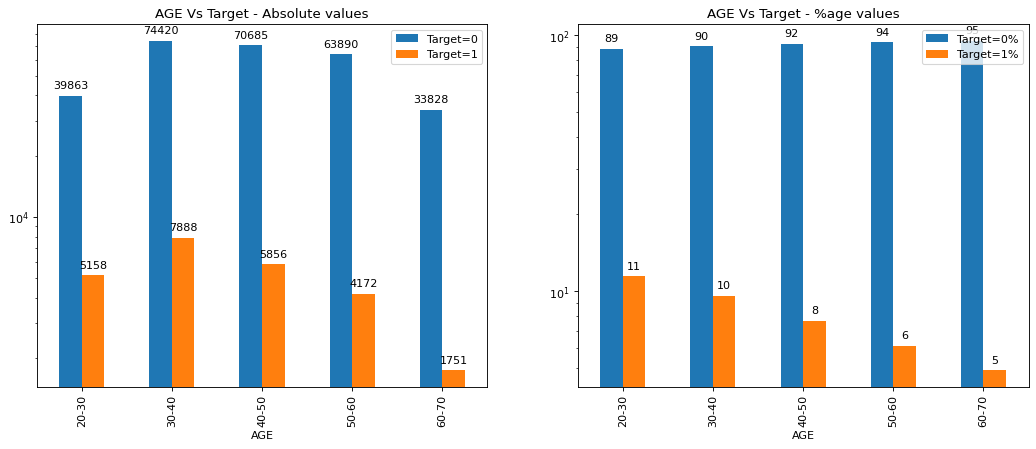

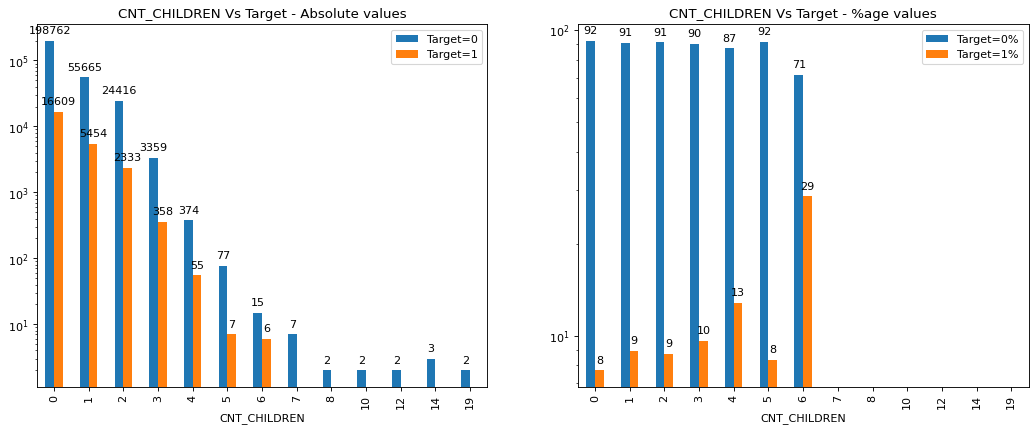

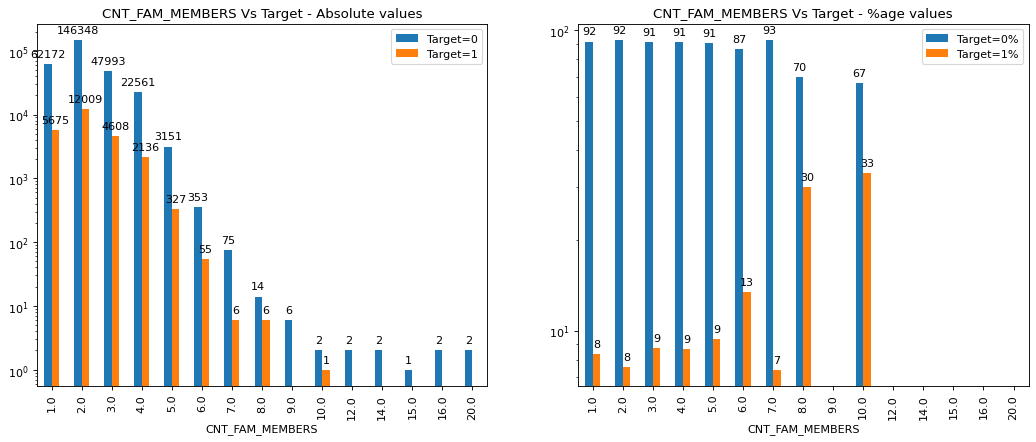

In [55]:
for col in ['AGE', 'CNT_CHILDREN', 'CNT_FAM_MEMBERS']:
    compare(df_ca_demo_per, col, col, figsize=(16, 6)) 

In [56]:
print(df_ca_demo_per[['REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY']].info())
print("REGION_RATING_CLIENT != REGION_RATING_CLIENT_W_CITY =", df_ca_demo_per.loc[df_ca_demo_per['REGION_RATING_CLIENT'] != df_ca_demo_per['REGION_RATING_CLIENT_W_CITY']].shape[0])
print("REGION_RATING_CLIENT  > REGION_RATING_CLIENT_W_CITY =", df_ca_demo_per.loc[df_ca_demo_per['REGION_RATING_CLIENT'] > df_ca_demo_per['REGION_RATING_CLIENT_W_CITY']].shape[0])
print("REGION_RATING_CLIENT  < REGION_RATING_CLIENT_W_CITY =", df_ca_demo_per.loc[df_ca_demo_per['REGION_RATING_CLIENT'] < df_ca_demo_per['REGION_RATING_CLIENT_W_CITY']].shape[0])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 2 columns):
 #   Column                       Non-Null Count   Dtype
---  ------                       --------------   -----
 0   REGION_RATING_CLIENT         307511 non-null  int64
 1   REGION_RATING_CLIENT_W_CITY  307511 non-null  int64
dtypes: int64(2)
memory usage: 4.7 MB
None
REGION_RATING_CLIENT != REGION_RATING_CLIENT_W_CITY = 5718
REGION_RATING_CLIENT  > REGION_RATING_CLIENT_W_CITY = 5718
REGION_RATING_CLIENT  < REGION_RATING_CLIENT_W_CITY = 0


Both REGION_RATING_CLIENT and REGION_RATING_CLIENT_W_CITY indicate a similar trait. So only one can be considered. REGION_RATING_CLIENT_W_CITY ratings >= REGION_RATING_CLIENT. So let's drop REGION_RATING_CLIENT and go only with REGION_RATING_CLIENT_W_CITY

In [57]:
# We need not drop the column. Just don't consider it
# dropColumns(df_ca_demo_per, ['REGION_RATING_CLIENT'])

REGION_RATING_CLIENT_W_CITY: ['2', '1', '3']
df_1: 24825, df_0: 282686
                              Total  Target=1  Target=0  Target=1%  Target=0%
REGION_RATING_CLIENT_W_CITY                                                  
1                             32197      1552     30645       4.82      95.18
2                            226984     17907    209077       7.89      92.11
3                             48330      5366     42964      11.10      88.90


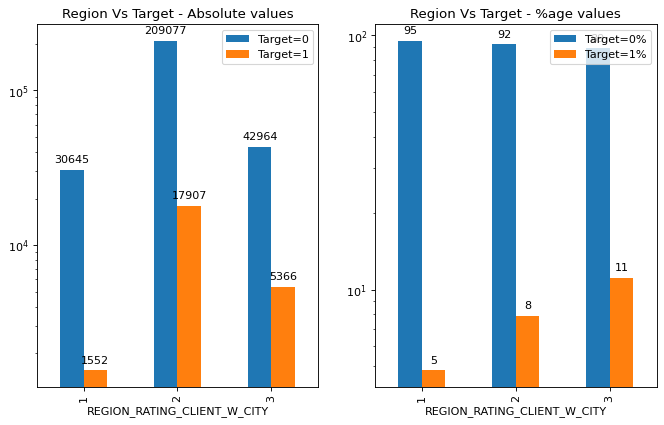

In [58]:
df_ca['REGION_RATING_CLIENT_W_CITY'] = df_ca['REGION_RATING_CLIENT'].apply(lambda x: str(x))
print('REGION_RATING_CLIENT_W_CITY:',df_ca['REGION_RATING_CLIENT_W_CITY'].unique().tolist())
compare(df_ca, 'REGION_RATING_CLIENT_W_CITY', 'Region')

#### **OBSERVATIONS**
| COLUMN(S) | Missing Values? | Outliers? | Observation | Difficulties in paying | No difficulties in paying | 
|---|---|---|---|---|---|
| AGE | None | None | With increase in age, the ability to pay increases. | Younger Clients | Older clients|
| CNT_CHILDREN | None | > 6 till 19 | With increase in number of kids, the ability to pay decreases.| More children | Less children |
| CNT_FAM_MEMBERS | None | > 8 till 20 | With increase in number of family members, the ability to pay decreases | Larger family size | Smaller family size |
| REGION_RATING_CLIENT, REGION_RATING_CLIENT | None | None | Higher the region, the clients find it more difficult to pay. Clients from regions 3 have difficulty in paying off | Higher Region category | Lower Region category |

- TODO: Look at rows that have invalid data.

### 2. Demographic - PROFESSIONAL

In [60]:
df_ca_demo_pro = df_ca[DEMOGRAPHIC_PROFESSIONAL + ['SK_ID_CURR', 'TARGET']]
print("Shape:",df_ca_demo_pro.shape)
print("Numerical values - describe:\n"); print(df_ca_demo_pro.describe())
print("Missing values:"); print(df_ca_demo_pro.isna().sum(), percent(df_ca_demo_pro.isna().sum(),df_ca_demo_pro.shape[0]))

Shape: (307511, 6)
Numerical values - describe:

          SK_ID_CURR         TARGET
count  307511.000000  307511.000000
mean   278180.518577       0.080729
std    102790.175348       0.272419
min    100002.000000       0.000000
25%    189145.500000       0.000000
50%    278202.000000       0.000000
75%    367142.500000       0.000000
max    456255.000000       1.000000
Missing values:
NAME_EDUCATION_TYPE        0
NAME_INCOME_TYPE           0
OCCUPATION_TYPE        96391
ORGANIZATION_TYPE          0
SK_ID_CURR                 0
TARGET                     0
dtype: int64 NAME_EDUCATION_TYPE     0.00
NAME_INCOME_TYPE        0.00
OCCUPATION_TYPE        31.35
ORGANIZATION_TYPE       0.00
SK_ID_CURR              0.00
TARGET                  0.00
dtype: float64


In [ ]:
def groupPerTargetLimited(df, col):
    df_1 = df[df['TARGET']==1][[col,'TARGET']]
    cnt_1 = df_1.shape[0]
    df_1 = groupByAndCount(df_1, col, sort = False)
    df_1.rename(columns={'Count':'Target=1'},inplace=True)
    #print(df_1)

    df_0 = df[df['TARGET']==0][[ col,'TARGET']]
    cnt_0 = df_0.shape[0]
    df_0 = groupByAndCount(df_0, col, sort = False)
    df_0.rename(columns={'Count':'Target=0'},inplace=True)
    #print(df_0)


    df_ = df_0.merge(df_1, how='left',on=col)
    df_['Total'] = df_['Target=0'] + df_['Target=1']
    df_['Target=0%'] = percent(df_['Target=0'], df_['Total']) 
    df_['Target=1%'] = percent(df_['Target=1'], df_['Total'])
    df_.set_index(col, inplace=True)

    #df_[['Total', 'Target=1', 'Target=0']].astype('int32')
    df_= df_[['Total', 'Target=1', 'Target=0', 'Target=1%', 'Target=0%' ]]

    print(f"df_1: {cnt_1}, df_0: {cnt_0}")
    print(df_)
    
    return df_

df_1: 24825, df_0: 282686
                                Total  Target=1  Target=0  Target=1%  \
NAME_EDUCATION_TYPE                                                    
Academic degree                   164         3       161       1.83   
Higher education                74863      4009     70854       5.36   
Incomplete higher               10277       872      9405       8.48   
Lower secondary                  3816       417      3399      10.93   
Secondary / secondary special  218391     19524    198867       8.94   

                               Target=0%  
NAME_EDUCATION_TYPE                       
Academic degree                    98.17  
Higher education                   94.64  
Incomplete higher                  91.52  
Lower secondary                    89.07  
Secondary / secondary special      91.06  
df_1: 24825, df_0: 282686
                         Total  Target=1  Target=0  Target=1%  Target=0%
NAME_INCOME_TYPE                                                     

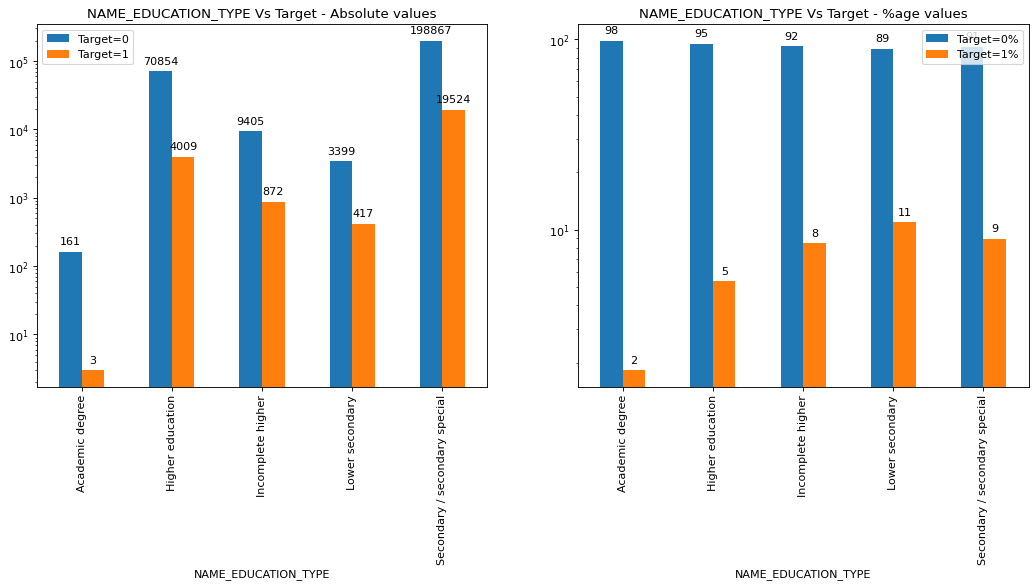

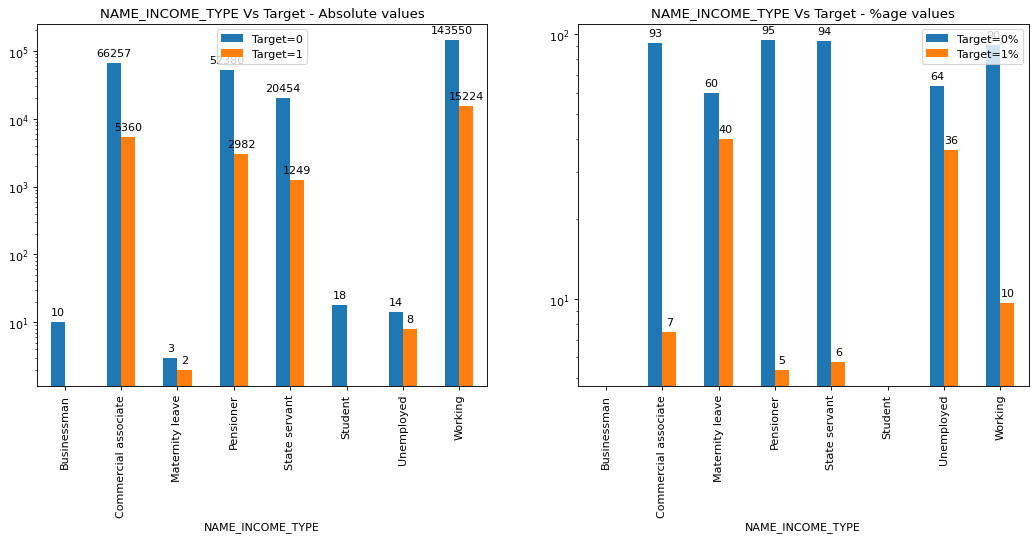

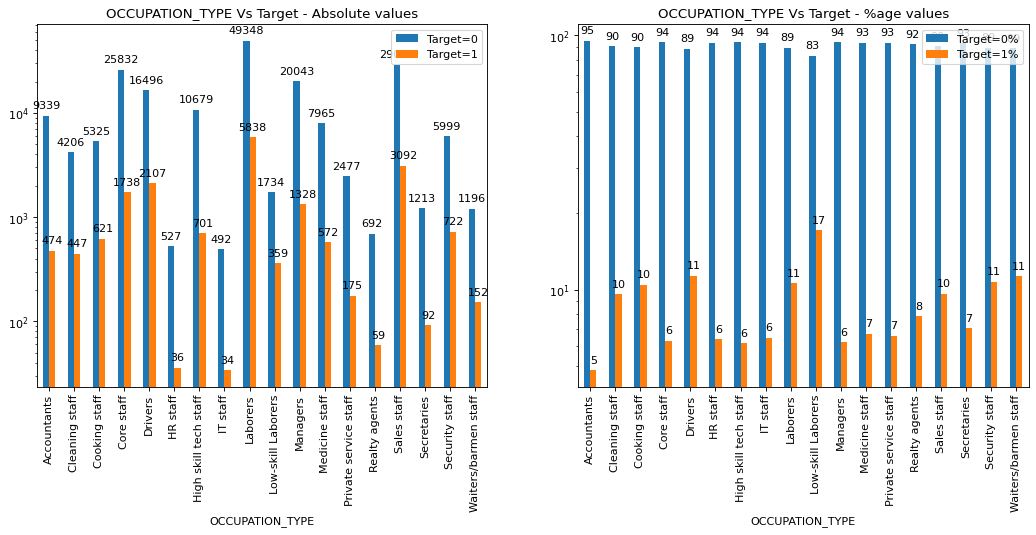

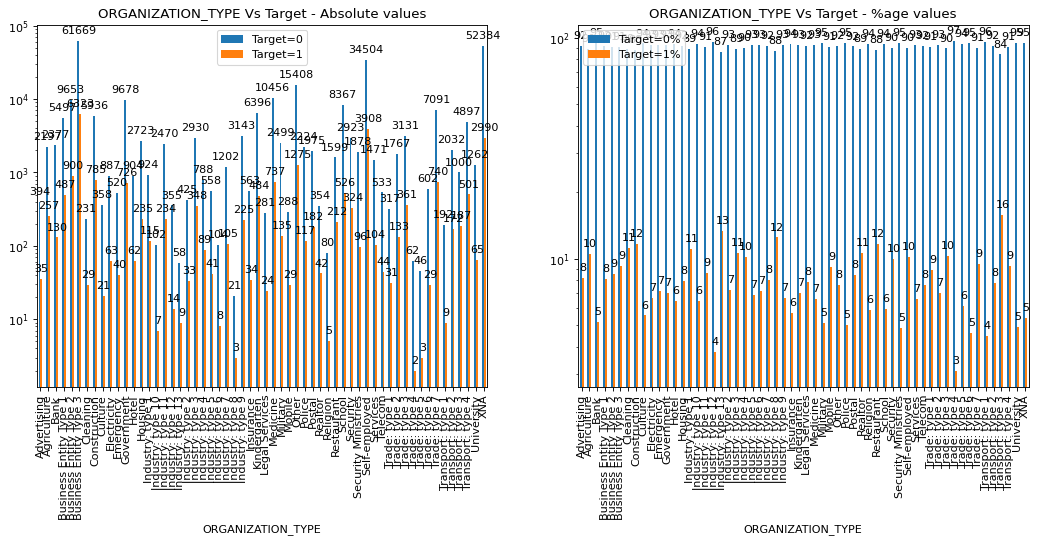

In [62]:
for col in DEMOGRAPHIC_PROFESSIONAL:
    compare(df_ca_demo_pro,col, col,figsize=(16, 6))

#### **OBSERVATIONS**
| COLUMN(S) | Missing Values? | Outliers? | Observation | Difficulties in paying | No difficulties in paying | 
|---|---|---|---|---|---|
| NAME_EDUCATION_TYPE | None | None | With increase in education, the ability to pay increases. | Clients with lesser education | Clients with higher education |
| NAME_INCOME_TYPE | None | None | With increase in age, the ability to pay increases. | Younger Clients | Older clients|
| OCCUPATION_TYPE | None | None | With increase in age, the ability to pay increases. | Younger Clients | Older clients|
| ORGANIZATION_TYPE | None | None | With increase in age, the ability to pay increases. | Younger Clients | Older clients|

### 2. Character - Credit Worthiness
- AMT_REQ_CREDIT_BUREAU_*
- 

In [ ]:
df_ca[(df_ca['SK_ID_CURR'].isin(curr_ids_multiple_prev_app))]['TARGET'].value_counts()
round(100. * df_ca['TARGET'].value_counts()/ len(df_ca['TARGET']),2)
df_ca[df_ca['TARGET'] == 1].to_csv("out/defaulter_curr_ids.csv")

In [ ]:
for col in ['AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK', 
            'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR']:
    print(f"{col}: {percent(df_ca[col].isna().sum(),df_ca.shape[0])}%")
    print(df_ca[col].unique().tolist())
    #compare(df_ca, col, col,figsize=(20, 10))

In [ ]:
col = 'AMT_REQ_CREDIT_BUREAU_QRT'
print(f"{col}: {percent(df_ca[col].isna().sum(),df_ca.shape[0])}%")
print(df_ca[col].unique().tolist())
compare(df_ca, col, col,figsize=(20, 10))

In [ ]:
compare(df_ca, 'OCCUPATION_TYPE', 'Occupation Type', ['Laborers', 'Core staff', 'Accountants', 'Managers','Drivers','Sales staff','Cleaning staff',
 'Cooking staff', 'Private service staff', 'Medicine staff', 'Security staff','High skill tech staff','Waiters/barmen staff',
 'Low-skill Laborers', 'Realty agents','Secretaries', 'IT staff', 'HR staff'], figsize=(20, 10))

#### OBSERVATIONS:
- **Gender**: More percentage of male clients have difficulties in paying off
- **Education**: Clients with lower education have difficulties in paying off. Clients with academic degree are paying off. 
- **Occupation**: Clients who are private service staff find it difficult in paying off
- **Housing Type**: Clients in REnted apartment or staying at parents house have difficulties in paying off

TODO: Add income-credit info here

#### Credit history

In [ ]:
df_pa.groupby(by='SK_ID_CURR').agg({'SK_ID_PREV':'count'})

In [ ]:
df_pa_ca_status = df_pa.pivot_table(index='SK_ID_CURR', values=['SK_ID_PREV'],columns=['NAME_CONTRACT_STATUS'], aggfunc=['count'],fill_value=0) 
df_pa_ca_status.columns = df_pa_ca_status.columns.droplevel()
df_pa_ca_status.columns = df_pa_ca_status.columns.droplevel()
df_pa_ca_status

In [ ]:
df_pa_ca_counts = df_pa.pivot_table(index='SK_ID_CURR', values=['SK_ID_PREV'], aggfunc=['count'],fill_value=0) 
df_pa_ca_counts.columns = df_pa_ca_counts.columns.droplevel()
df_pa_ca_counts.rename(columns={'SK_ID_PREV':'Total Prev Apps'}, inplace=True)
df_pa_ca_counts

In [ ]:
df_pa_ca = df_pa_ca_counts.merge(df_pa_ca_status, how='inner', on='SK_ID_CURR')
df_pa_ca.reset_index(inplace=True)
df_pa_ca

In [ ]:
df_pa_ca['Refused%'] = round((df_pa_ca['Refused']/df_pa_ca['Total Prev Apps'])*100,2)
df_pa_ca[df_pa_ca['Refused%'] > 50].sort_values(by='Refused%', ascending= False)

In [ ]:
print(df_pa.shape[0], df_pa_ca['Total Prev Apps'].sum())

In [ ]:
curr_ids_rej_pa = df_pa_ca[df_pa_ca['Refused%'] > 75 ]['SK_ID_CURR']
print(curr_ids_rej_pa.shape[0])
curr_ids_rej_pa = curr_ids_rej_pa.tolist()
curr_ids_rej_pa[0:4]

In [ ]:
df_ca[df_ca['SK_ID_CURR'].isin(curr_ids_rej_pa)]#.groupby('TARGET').agg({'TARGET':'count'})

In [ ]:
pa_curr_ids = df_pa['SK_ID_CURR'].unique().tolist(); print(type(pa_curr_ids), len(pa_curr_ids), pa_curr_ids[0:4])
ca_curr_ids = df_ca['SK_ID_CURR'].unique().tolist(); print(type(ca_curr_ids), len(ca_curr_ids), ca_curr_ids[0:4])

curr_ids_with_prev_apps = list(set(pa_curr_ids) & set(ca_curr_ids))
print("Curr ids with prev apps:", type(curr_ids_with_prev_apps), len(curr_ids_with_prev_apps), curr_ids_with_prev_apps[0:4])

curr_ids_wo_prev_apps = set(ca_curr_ids).difference(set(pa_curr_ids))
print("Curr ids w/o prev apps:", type(curr_ids_wo_prev_apps), len(curr_ids_wo_prev_apps), list(curr_ids_wo_prev_apps)[0:4])

print("Verification: ", len(curr_ids_with_prev_apps) + len(curr_ids_wo_prev_apps), len(ca_curr_ids))

### 3. Capacity <a class="anchor" id="capacity"></a>
Borrower's ability to repay the loan
- Debt-to-income (DTI) ratio = total monthyl dept/gross monthly income
- DTI < 35% is safe
- Length of time an applicant is employed at their current job

Columns
- INCOME
- FLAG_OWN_CAR, FLAG_OWN_REALTY

* [Realty & Car](#realty-car)
* [Income](#income)

Borrower's ability to repay the loan
- Current debt
- Income
- Length of time employed at current job


COLUMNS
- FLAG_OWN_CAR      - categorical
- FLAG_OWN_REALTY   - categorical
- AMT_INCOME_TOTAL  - numerical, continuous, float

- FLAG_OWN_REALTY == 'Y' does not mean the client is staying there.
- NAME_HOUSING_TYPE indicates the type of housing where the client is staying. Not what he/she owns.

In [ ]:
df_ca[df_ca['FLAG_OWN_REALTY'] == 'Y'][['SK_ID_CURR','NAME_HOUSING_TYPE']].sort_values(by='NAME_HOUSING_TYPE', ascending=False)
df_ca[ (df_ca['FLAG_OWN_REALTY'] == 'N') & (~ df_ca['NAME_HOUSING_TYPE'].isna()) ][['SK_ID_CURR','FLAG_OWN_REALTY', 'NAME_HOUSING_TYPE']]

In [ ]:
for col in ['FLAG_OWN_CAR', 'FLAG_OWN_REALTY','NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE','NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE']:
    df_= makeDFForTargets(df_ca, col)
    plotBar(df_, f"{col} Vs Target")
df_ca['AMT_INCOME_TOTAL']
df_ca.boxplot(column='AMT_INCOME_TOTAL', by='TARGET', figsize = (20, 6))
df_ca.quantile([0.9, 0.95, .9999])['AMT_INCOME_TOTAL']
CA_CLIENT_COLUMNS = df_columns[(df_columns['Table']=='application_data') & (df_columns['Category']=='CLIENT')]['Row'].tolist()
CA_APPLICATION_COLUMNS = df_columns[(df_columns['Table']=='application_data') & (df_columns['Category']=='APPLICATION')]['Row'].tolist()
CA_BUILDING_COLUMNS = df_columns[(df_columns['Table']=='application_data') & (df_columns['Category']=='BUILDING')]['Row'].tolist()
df_ca_maxincome = df_ca.iloc[df_ca['AMT_INCOME_TOTAL'].idxmax()][['SK_ID_CURR','AMT_INCOME_TOTAL'] + CA_CLIENT_COLUMNS ]
df_ca_maxincome[CA_CLIENT_COLUMNS]

#### Income, Credit, Goods

In [ ]:
df_ca.iloc[df_ca['AMT_INCOME_TOTAL'].idxmax()][['SK_ID_CURR','AMT_INCOME_TOTAL']]

In [ ]:

df_ca_red = df_ca[df_ca['SK_ID_CURR'] != 114967]
print(df_ca.shape[0], df_ca_red.shape[0])

In [ ]:
plt.figure(figsize=(20, 6), dpi=80)
plt.subplot(1, 3, 1)
ax = sns.scatterplot(df_ca_red['AMT_INCOME_TOTAL'], df_ca_red['AMT_CREDIT']); ax.set_xscale('log'); ax.set_title("Income Vs Credit")
plt.subplot(1, 3, 2)
ax = sns.scatterplot(df_ca_red['AMT_INCOME_TOTAL'], df_ca_red['AMT_GOODS_PRICE']); ax.set_xscale('log'); ax.set_title("Income Vs Goods Price")
plt.subplot(1, 3, 3)
ax = sns.scatterplot(df_ca_red['AMT_GOODS_PRICE'], df_ca_red['AMT_CREDIT']); ax.set_title("Goods Price Vs Credit")
plt.show()

# TODO: How to get the outliers? 

#### Realty Car <a name="realty-car"></a>

In [ ]:
print("Missing values: ")
for col in ['FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'AMT_INCOME_TOTAL']:
    print(f"{col:27}: {df_ca[col].isna().sum():7}")
df_ca[df_ca['FLAG_OWN_CAR'] == 'Y'][['SK_ID_CURR','OWN_CAR_AGE']].sort_values(by='OWN_CAR_AGE', ascending=False)
# TODO: OWN_CAR_AGE has NaN values where FLAG_OWN_CAR='Y'
# OWN_CAR_AGE - what is the unit? Is it in months or days?
#  Verify if car is not owned but has car age provided
df_ca[ (df_ca['FLAG_OWN_CAR'] == 'N') & (~df_ca['OWN_CAR_AGE'].isna()) ][['SK_ID_CURR','FLAG_OWN_CAR', 'OWN_CAR_AGE']]
for col in ['FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
    df_= makeDFForTargets1(df_ca, col)
    print(df_.columns.to_list())
    plotBar(df_, f"{col} Vs Target")

# Whether a client owns a car/house or not does not seem to impact their ability to make payment

#### Income <a class="anchor" id="income"></a>

In [ ]:
df_ca.boxplot(column='AMT_INCOME_TOTAL', by='TARGET', figsize = (20, 6))

The boxplot shows that most of the incomes lie in a small range. While a few are extremely high. Is there a better visualization of this?

In [ ]:
#df_ca.plot.line(x='AMT_INCOME_TOTAL')

In [ ]:
df_ca.hist('AMT_INCOME_TOTAL', bins=228)

In [ ]:
# AMT_INCOME_TOTAL - numerical, continuous, float
# - No missing values
# - The spread is very skewed. So bin the income groups
# - Are there any particular income groups that struggle to pay back loans? or pay comfortably?
# - Income and other variables like credit amount
print(df_ca[['AMT_INCOME_TOTAL']].mean(), df_ca[['AMT_INCOME_TOTAL']].median())
print(df_ca[['AMT_INCOME_TOTAL']].quantile([0, 0.00005, 0.0005, 0.005, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99999, 1]))

In [ ]:
print(getIQR(df_ca,'AMT_INCOME_TOTAL'), getMaxScore(df_ca,'AMT_INCOME_TOTAL'))

In [ ]:
# Bin the AMT_INCOME_TOTAL into smaller groups
df_ca_copy = df_ca.copy()
df_ca_copy['INCOME_GROUP'] = pd.cut(df_ca_copy['AMT_INCOME_TOTAL'], [0, 50000, 100000, 1000000, 5000000, 200000000], labels=['<50K', '<1L', '<10L', '<50L', '>50L'])
income_groups = df_ca_copy['INCOME_GROUP'].value_counts(sort=False)
print(income_groups)
#plotBar(income_groups,"Income Groups", w=8, h=4, logy=True)

# Group the income bins based on TARGET
df_ca_copy_income = groupPerTarget(df_ca_copy, 'INCOME_GROUP')
plotBar(df_ca_copy_income[['Target=0%','Target=1%']], "Income Vs Target")

df_ca_copy_income

# TODO: 
# - Add % in the annotation
# - Plot according to quartile and check

##### **Observations**
- The spread of the income is very high. So binned the income groups

In [ ]:
df_ca.iloc[df_ca['AMT_INCOME_TOTAL'].idxmax()][['SK_ID_CURR','AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_GOODS_PRICE']] # + CA_CLIENT_COLUMNS ]

In [ ]:
df_ca_max_income = df_ca[df_ca['SK_ID_CURR'] < 114967]
id, income, credit, goods_price = df_ca.iloc[df_ca['AMT_INCOME_TOTAL'].idxmax()][['SK_ID_CURR','AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_GOODS_PRICE']].to_list()
print(id, income, credit, goods_price, round(100 * credit/income,2))
print(100 * df_ca_max_income['AMT_CREDIT']/df_ca_max_income['AMT_INCOME_TOTAL'])

Max income value is 11 crores. Goods price is 4.5L and credit value is 5.6 L. The loan amount is < 1% of the income which seems bizzare. This can be removed.

In [ ]:
df_ca_red = df_ca[df_ca['AMT_INCOME_TOTAL'] < getMaxScore(df_ca,'AMT_INCOME_TOTAL')]
print(df_ca.shape[0], df_ca_red.shape[0])

In [ ]:
# Outliers - box plot
df_ca_red.boxplot(column='AMT_INCOME_TOTAL', by='TARGET', figsize = (20, 6))

### 4. Capital
- Down payment indicates borrower's level of seriousness
- Downpayment size
- Overall wealth that borrower possess - Car, Realty

#### Building

In [ ]:
df_ca[CA_BUILDING_COLUMNS]
df_ca['BUILDING'] = 0
for col in ['APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI', 'LANDAREA_MEDI', 'LIVINGAREA_MEDI', 'NONLIVINGAREA_MEDI']:
    print(f"{col}: {percent(df_ca[col].isna().sum(), df_ca.shape[0])}%")
    df_ca['BUILDING'] = df_ca[col]
print(f"BUILDING {percent(df_ca['BUILDING'].isna().sum(), df_ca.shape[0])}%")

- Since most information about the building is not present we could ignore this variable in our analysis

#### Application

In [ ]:
df_ca['OWN_CAR_AGE'].describe()
for col in ['AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE']:
    df_ca.boxplot(column=col, by='TARGET', figsize = (20, 6))

In [ ]:
df_ca[['SK_ID_CURR'] + CA_APPLICATION_COLUMNS]

In [ ]:
CA_FLAG_DOCUMENT_COLUMNS = list(filter(lambda x: x[:14] == 'FLAG_DOCUMENT_', df_ca.columns.tolist()))
CA_FLAG_DOCUMENT_COLUMNS

In [ ]:
import functools
#df_ca['FLAG_DOCUMENT'] = df_ca[CA_FLAG_DOCUMENT_COLUMNS].apply(lambda row: functools.reduce(lambda a, b: a+b, row))
df_ca['FLAG_DOCUMENT'] = functools.reduce(lambda a, b: a+b, [df_ca[col] for col in CA_FLAG_DOCUMENT_COLUMNS])
df_ca[['SK_ID_CURR', 'FLAG_DOCUMENT'] + CA_FLAG_DOCUMENT_COLUMNS]

In [ ]:
df_ca['FLAG_DOCUMENT'].describe()

In [ ]:
#  df_ca.plot.bar('FLAG_DOCUMENT', figsize = (20, 6))
df_ca['FLAG_DOCUMENT'].value_counts()

In [ ]:
df_ca[df_ca['FLAG_DOCUMENT']==4]

## Data Standardisation
- Remove decimals from the amounts
- Convert age to years & months - not days
- Convert amounts to K or L? 
- Convert numeric flags to categorical values

## Data Cleaning - Handle missing data

In [ ]:
## Missing Values
listColumsWithMissingData(df_ca)

In [ ]:
listColumsWithMissingData(df_pa)

## Outliers

## Correlation 

In [ ]:
df_ca.columns.tolist()[:50]

In [ ]:
sns.heatmap(df_ca[['AMT_INCOME_TOTAL','AMT_CREDIT','AMT_GOODS_PRICE','TARGET']].corr());plt.show()

In [ ]:
sns.pairplot(data=df_ca_red[['AMT_INCOME_TOTAL','AMT_CREDIT','AMT_GOODS_PRICE','TARGET']])

In [ ]:
plotBar(df_ca_red['CNT_CHILDREN'])